# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
# NOTE: one must reload matplotlib to change of rendering style
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Churn Prediction

Any subscription-based business is committed to keep their customer happy in exchange for their loyalty. Despite their efforts, some customers will eventually not renew their subscription. In this latter case, if a customer has not renewed within a time window after its subscription expiration date, this customer is said to have churned. Although each service provider offers several subscription options (monthly, yearly, basic, premium,...), the time window to consider a customer has churned varies quite a lot. It seems that each company sets their own.

This project is based on a [Kaggle competition](https://www.kaggle.com/c/kkbox-churn-prediction-challenge) where KKBOX, an Asian leading __music streaming service__, is interested in learning from their customer behavior to prevent them from churning.

The __grace period is 30 days__ in order to consider a customer has churned after its current membership ends. The goal is to determine churn from one month to the next.

# Classification Labels
Churn prediction is a classification problem where the ouput is binary. There is only two possible outcomes, either customer churned or keep their subscription. 

KKBOX provides a train.csv file that contains users identification and whether they have churned or not for the month of February 2017. Most users do not churn therefore we don't have many data points where users churned.

In [2]:
# train.csv only contains 
train_dir = os.path.join(os.pardir, 'data', 'raw', 'train.csv')
df_train = pd.read_csv(train_dir, index_col = 'msno')

In [3]:
df_train.head()

,is_churn
msno,
waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992931 entries, waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y= to ZoVEIVMCpKT9/MJgqO+fh9xYrNM2vNisLhJ4xY/CVyk=
Data columns (total 1 columns):
is_churn    992931 non-null int64
dtypes: int64(1)
memory usage: 15.2+ MB


(0.0, 1.05, -0.44000000000000006, 0.44000000000000006)

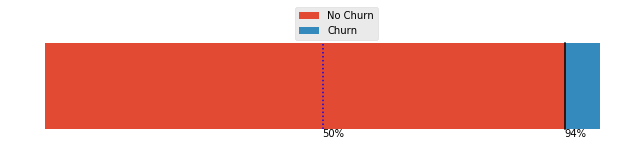

In [5]:
# axes configuration
_ , axChurn = plt.subplots(figsize=(9, 2))
axChurn.set_position([0.05, 0.05, 0.9, 0.65])

# histogram via value_counts()
churn_distrib = df_train.is_churn.value_counts(normalize=True)

# bar plot of no churn first
no_churn = churn_distrib.loc[0]
axChurn.barh(0, no_churn)

# bar plot of churn stacked on no churn horizontally
h_bar2 = axChurn.barh(0, churn_distrib.loc[1],  left = no_churn)

# add legend
axChurn.legend(['No Churn', 'Churn'], bbox_to_anchor=(0.5,1.4), loc = 'upper center')

# show a line at 50% if it were balanced
bar_height = h_bar2.patches[-1].get_height()/2
axChurn.plot([0.5]*2, [-bar_height, bar_height], color = 'b', linestyle = ':')
axChurn.text(0.5,-bar_height*1.2, '50%')

# show a line at the atually split of no churn - churn
axChurn.plot([no_churn]*2, [-bar_height, bar_height], color = 'k', linestyle = '-')
axChurn.text(no_churn,-bar_height*1.2, '{:.0f}%'.format(no_churn*100))

# removes axis spines altogether
axChurn.axis('off')

In [6]:
# ALTERNATIVE SOLUTION TO GENERATE THE SAME PLOT
# _ , axChurn = plt.subplots(figsize=(10, 2))

# # one could histogram is_churn column directly but it doesn't look good
# # df_train.is_churn.plot(kind='hist', bins=[0, 1, 2], rwidth=0.5, align = 'left', ax=axChurn)

# # histogram via value_counts() then make bar plot, change ticks labels
# # churn_distrib = df_train.is_churn.value_counts()
# # churn_distrib.plot(kind='barh', ax=axChurn)
# # axChurn.set_yticklabels(('No Churn', 'Churn'), rotation = 0)
# ## plt.xticks(churn_distrib.index, ('No Churn', 'Churn'), rotation = 0)

# Data Description
There 3 data files that can tell us about customer behavior.

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



|              user_logs.csv                                              |
|-------------------------------------------------------------------------|
| msno       | user id  (letters, digits and special characters)          |
| date       | format %Y%m%d                                              |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

|                                    members.csv                  |
|---------------------------------|-------------------------------|
| msno                            |user id  (letters, digits and special characters) |
| city                            |          name of city         |
| bd                              | age$^i$                       |
| gender                          |            gender             |
| registered_via                  |     registration method       |
| registration_init_time          |          format %Y%m%d        |
| expiration_date                 | format %Y%m%d $^{ii}$         |

$^i$ this column has outlier values ranging from -7000 to 2015 please use your judgement.

$^{ii}$ taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.